In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgba
from rasterio.plot import show
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import xml.etree.ElementTree as ET
import geopandas as gpd

# Data prep for canada data

Data from https://open.canada.ca/data/en/dataset/d4f80bd3-17e3-a7e8-4bfe-d22a430678d5


In [18]:
# --- Parse QGIS QML palette ---
def parse_qgis_qml_palette(qml_file):
    """
    Returns dict: {int(value): {"name": label, "color": "#RRGGBB"}}
    """
    tree = ET.parse(qml_file)
    root = tree.getroot()
    # Find all paletteEntry nodes under a paletted rasterrenderer
    entries = root.findall(".//rasterrenderer[@type='paletted']/colorPalette/paletteEntry")
    mapping = {}
    for e in entries:
        val = int(e.attrib["value"])
        label = e.attrib.get("label", str(val))
        color = e.attrib.get("color", "#000000")
        # QGIS color may be "#RRGGBB" or "r,g,b,a"
        if "," in color:
            r, g, b, *rest = [int(x) for x in color.split(",")]
            a = int(rest[0]) if rest else 255
            color = to_rgba((r/255, g/255, b/255, a/255))
        else:
            # Ensure hex works for matplotlib (convert to RGBA)
            color = to_rgba(color)
        mapping[val] = {"name": label, "color": color}
    return mapping

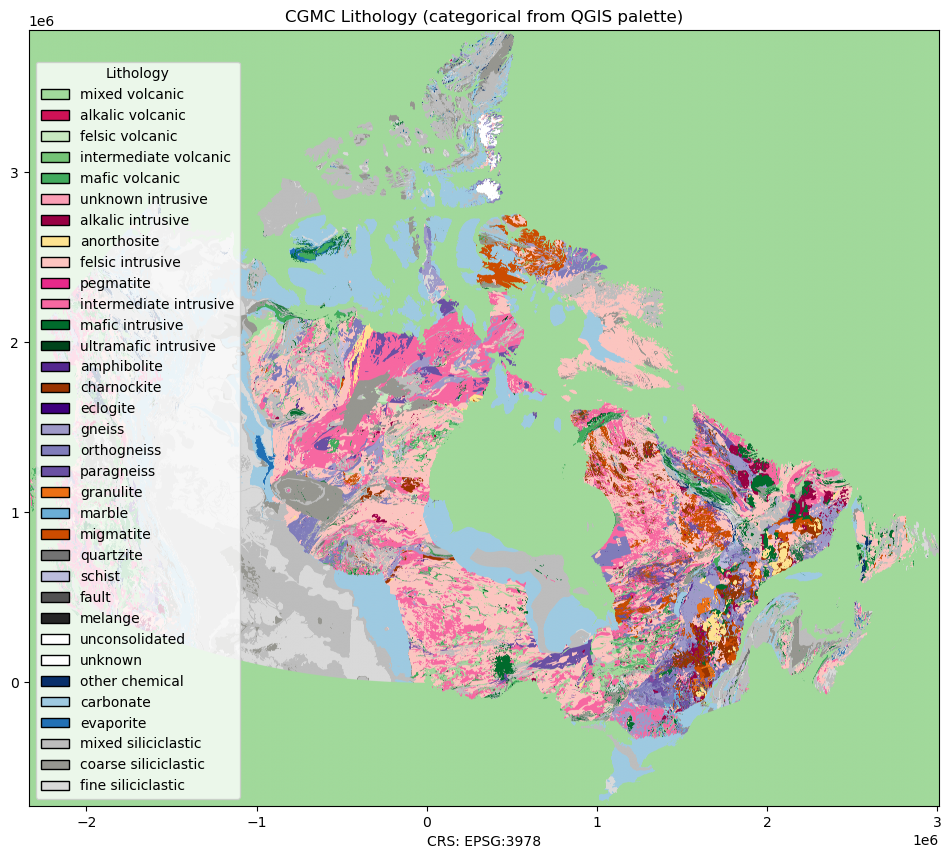

In [19]:
in_tiff = "2024_CGMC_Lithology_EPSG3978.tif"
qml_path = "compil_geologic_map_en.qml"
labels = parse_qgis_qml_palette(qml_path)

with rasterio.open(in_tiff) as src:
    data = src.read(1)
    nodata = src.nodata
    mask = np.ones_like(data, dtype=bool)
    if nodata is not None:
        mask &= (data != nodata)

    present_vals = np.unique(data[mask]).tolist()
    # Keep only the classes that have labels/colors defined
    vals = sorted(v for v in present_vals if v in labels)
    if not vals:
        raise ValueError("No labeled classes found in the raster for plotting. Check qml vs raster values.")

    # Build parallel lists for names/colors
    names = [labels[v]["name"] for v in vals]
    colors = [labels[v]["color"] for v in vals]

    # Create discrete colormap + norm:
    # We'll remap values -> 0..K-1 indices for compact colormap
    val_to_idx = {v: i for i, v in enumerate(vals)}
    remap = np.full_like(data, fill_value=-1, dtype=int)
    remap[mask] = np.vectorize(val_to_idx.get, otypes=[int])(data[mask])

    cmap = ListedColormap(colors)
    # Since remap is 0..K-1, boundaries are centered on integers
    boundaries = np.arange(len(vals) + 1) - 0.5
    norm = BoundaryNorm(boundaries, ncolors=cmap.N)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(11, 9))
    show(remap, transform=src.transform, cmap=cmap, norm=norm, ax=ax)
    ax.set_title("CGMC Lithology (categorical from QGIS palette)")

    # Legend — only present classes (nice and tidy)
    handles = [Patch(facecolor=colors[i], edgecolor='k', label=names[i]) for i in range(len(vals))]
    # Tweak ncol if you have many classes
    ax.legend(handles=handles, title="Lithology", loc="lower left", frameon=True, ncol=1)

    ax.set_xlabel(f"CRS: {src.crs.to_string()}")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

# check new dataset

In [27]:
# --- Reproject to EPSG:4326 ---
dst_crs = "EPSG:4326"

proj_tif = "geol_canada_4326.tif"

with rasterio.open(in_tiff) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "compress": "deflate",
        "predictor": 2,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
    })

    with rasterio.open(proj_tif, "w", **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )

print("Reprojected raster saved as:", proj_tif)

Reprojected raster saved as: geol_canada_4326.tif


CRS: EPSG:4326
Bounds: BoundingBox(left=-173.45519671566532, bottom=35.83699207910679, right=-12.017054474044102, top=83.77371877320553)
Shape (rows, cols): 14554 49014
Number of bands: 1


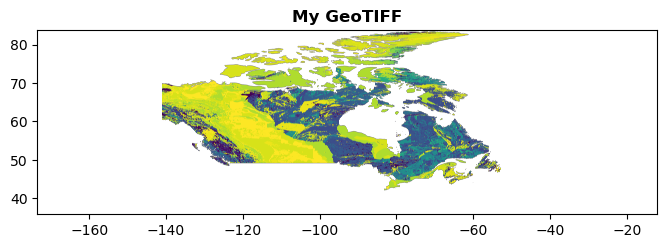

In [28]:
with rasterio.open(proj_tif) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (rows, cols):", src.height, src.width)
    print("Number of bands:", src.count)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    img = show(src, ax=ax, title="My GeoTIFF")
    # cbar = plt.colorbar(img.get_images()[0], ax=ax, shrink=0.8)
    # cbar.set_label("Raster value")
    plt.show()

# Crop to cascadia only

In [29]:
cropped_tif = "canada_geol_bbox_4326.tif"

bbox_ll = (-130.0, 32.0, -113.0, 52.0)   # (minx, miny, maxx, maxy) in EPSG:4326

from pyproj import Transformer
with rasterio.open(proj_tif) as src:
    window = from_bounds(*bbox_ll, transform=src.transform)
    data = src.read(1, window=window)
    out_transform = src.window_transform(window)

    profile = src.profile.copy()
    profile.update({
        "height": data.shape[0],
        "width":  data.shape[1],
        "transform": out_transform,
        "compress": "deflate",
        "predictor": 2,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
    })

    with rasterio.open(cropped_tif, "w", **profile) as dst:
        dst.write(data, 1)

print("Wrote:", cropped_tif)

Wrote: canada_geol_bbox_4326.tif


CRS: EPSG:4326
Bounds: BoundingBox(left=-130.0, bottom=35.837740972382676, right=-113.00113738709334, top=52.0)
Shape (rows, cols): 4907 5161
Number of bands: 1


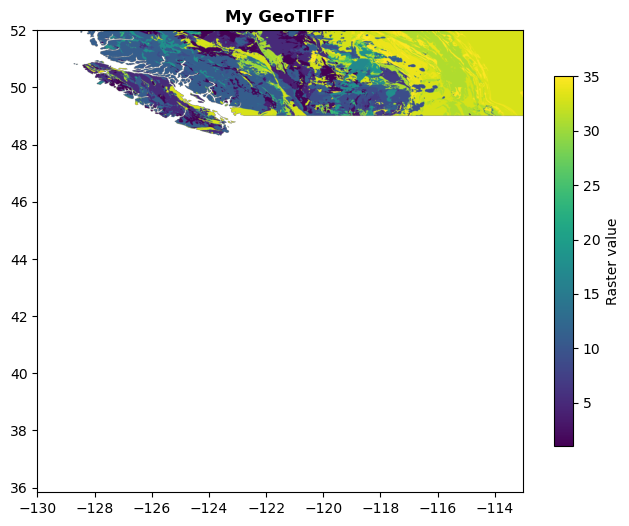

In [3]:
cropped_tif = "canada_geol_bbox_4326.tif"

with rasterio.open(cropped_tif) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (rows, cols):", src.height, src.width)
    print("Number of bands:", src.count)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    img = show(src, ax=ax, title="My GeoTIFF")
    cbar = plt.colorbar(img.get_images()[0], ax=ax, shrink=0.8)
    cbar.set_label("Raster value")
    plt.show()

# US

Data from : https://ngmdb.usgs.gov/Prodesc/proddesc_118545.htm


In [3]:
gdf_us = gpd.read_file("ngs_surface_2025_v1.gdb", layer="MapUnitPolys")
print(gdf_us.crs)  # often EPSG:269xx or 5070 (Albers)

EPSG:5070


In [4]:
gdf_us = gdf_us.to_crs(4326)
gdf_us

,Shape_Length,Shape_Area,MapUnit,IdentityConfidence,Label,Symbol,DataSourceID,Notes,MapUnitPolys_ID,MapSourceID,Source_MapUnit,geometry
0,7493.058271,1.429368e+06,Zm,certain,None,431,908,None,5_1,map32,32|Zaa,"MULTIPOLYGON (((-80.34567 36.91298, -80.34287 ..."
1,20650.409749,4.108356e+06,Zm,certain,None,431,908,None,5_2,map32,32|Zaa,"MULTIPOLYGON (((-80.57775 36.82387, -80.57733 ..."
2,23129.241987,3.550581e+06,Zm,certain,None,431,908,None,5_3,map32,32|Zaa,"MULTIPOLYGON (((-80.57772 36.82119, -80.5791 3..."
3,15880.110199,1.887002e+06,Zm,certain,None,431,908,None,5_4,map32,32|Zaa,"MULTIPOLYGON (((-81.07106 36.59942, -81.07244 ..."
4,44229.925157,7.375094e+06,Zm,certain,None,431,908,None,5_5,map32,32|Zaa,"MULTIPOLYGON (((-80.64167 36.78527, -80.63969 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
443658,11991.298833,4.450635e+06,MZim,certain,None,359,1652,None,5_443666,map112,112|Kog,"MULTIPOLYGON (((-116.81791 47.90751, -116.8160..."
443659,27635.441056,2.491294e+07,MZim,certain,None,359,1652,None,5_443667,map112,112|Kog,"MULTIPOLYGON (((-116.79139 48.35965, -116.7816..."
443660,25001.627044,1.537593e+07,MZim,certain,None,359,1652,None,5_443668,map112,112|Ji,"MULTIPOLYGON (((-116.84869 42.74183, -116.8468..."
443661,36751.367467,3.748959e+07,MZim,certain,None,359,1652,None,5_443669,map112,112|Ji,"MULTIPOLYGON (((-115.5088 43.47209, -115.5027 ..."


In [6]:
bbox_ll = (-130.0, 32.0, -113.0, 52.0)   # (minx, miny, maxx, maxy) in EPSG:4326
gdf_us = gdf_us.cx[bbox_ll[0]:bbox_ll[2], bbox_ll[1]:bbox_ll[3]]
gdf_us

,Shape_Length,Shape_Area,MapUnit,IdentityConfidence,Label,Symbol,DataSourceID,Notes,MapUnitPolys_ID,MapSourceID,Source_MapUnit,geometry
10357,6614.859501,1.001052e+06,Zs,certain,None,523,835,None,5_10358,map22,22|Zw,"MULTIPOLYGON (((-118.1777 37.72049, -118.17118..."
10358,19477.118811,8.297441e+06,Zs,certain,None,523,835,None,5_10359,map22,22|Zw,"MULTIPOLYGON (((-118.19637 37.78259, -118.1928..."
10359,1997.454521,2.212833e+05,Zs,certain,None,523,835,None,5_10360,map22,22|Zw,"MULTIPOLYGON (((-118.1169 37.67971, -118.12189..."
10360,2528.236324,3.506022e+05,Zs,certain,None,523,835,None,5_10361,map22,22|Zw,"MULTIPOLYGON (((-118.17149 37.71178, -118.1719..."
10361,20197.891019,6.896528e+06,Zs,certain,None,523,835,None,5_10362,map22,22|Zw,"MULTIPOLYGON (((-117.22475 37.2822, -117.22284..."
...,...,...,...,...,...,...,...,...,...,...,...,...
443658,11991.298833,4.450635e+06,MZim,certain,None,359,1652,None,5_443666,map112,112|Kog,"MULTIPOLYGON (((-116.81791 47.90751, -116.8160..."
443659,27635.441056,2.491294e+07,MZim,certain,None,359,1652,None,5_443667,map112,112|Kog,"MULTIPOLYGON (((-116.79139 48.35965, -116.7816..."
443660,25001.627044,1.537593e+07,MZim,certain,None,359,1652,None,5_443668,map112,112|Ji,"MULTIPOLYGON (((-116.84869 42.74183, -116.8468..."
443661,36751.367467,3.748959e+07,MZim,certain,None,359,1652,None,5_443669,map112,112|Ji,"MULTIPOLYGON (((-115.5088 43.47209, -115.5027 ..."


In [9]:
# --- Load DescriptionOfMapUnits table ---
df_dmu = gpd.read_file("ngs_surface_2025_v1.gdb", layer="DescriptionOfMapUnits")

df_dmu = df_dmu[["MapUnit", "Name"]].rename(columns={"Name": "UnitName"})
gdf_joined = gdf_us.merge(df_dmu, on="MapUnit", how="left")
keep = ["MapUnit", "UnitName", "geometry"]
gdf_joined = gdf_joined[keep]
print(gdf_joined.head())

  MapUnit                   UnitName  \
0      Zs  Clastic sedimentary rocks   
1      Zs  Clastic sedimentary rocks   
2      Zs  Clastic sedimentary rocks   
3      Zs  Clastic sedimentary rocks   
4      Zs  Clastic sedimentary rocks   

                                            geometry  
0  MULTIPOLYGON (((-118.1777 37.72049, -118.17118...  
1  MULTIPOLYGON (((-118.19637 37.78259, -118.1928...  
2  MULTIPOLYGON (((-118.1169 37.67971, -118.12189...  
3  MULTIPOLYGON (((-118.17149 37.71178, -118.1719...  
4  MULTIPOLYGON (((-117.22475 37.2822, -117.22284...  


In [10]:
out_file = "us_surface_geology_named.gpkg"
gdf_joined.to_file(out_file, layer="surface_geology", driver="GPKG")
print("✅ Saved:", out_file, "with", len(gdf_joined), "polygons")

✅ Saved: us_surface_geology_named.gpkg with 80094 polygons


C:\Users\loicb\AppData\Local\Temp\ipykernel_1664\1765706521.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  labels = (gdf_plot.assign(_area=gdf_plot.geometry.area)
C:\Users\loicb\AppData\Local\Temp\ipykernel_1664\1765706521.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


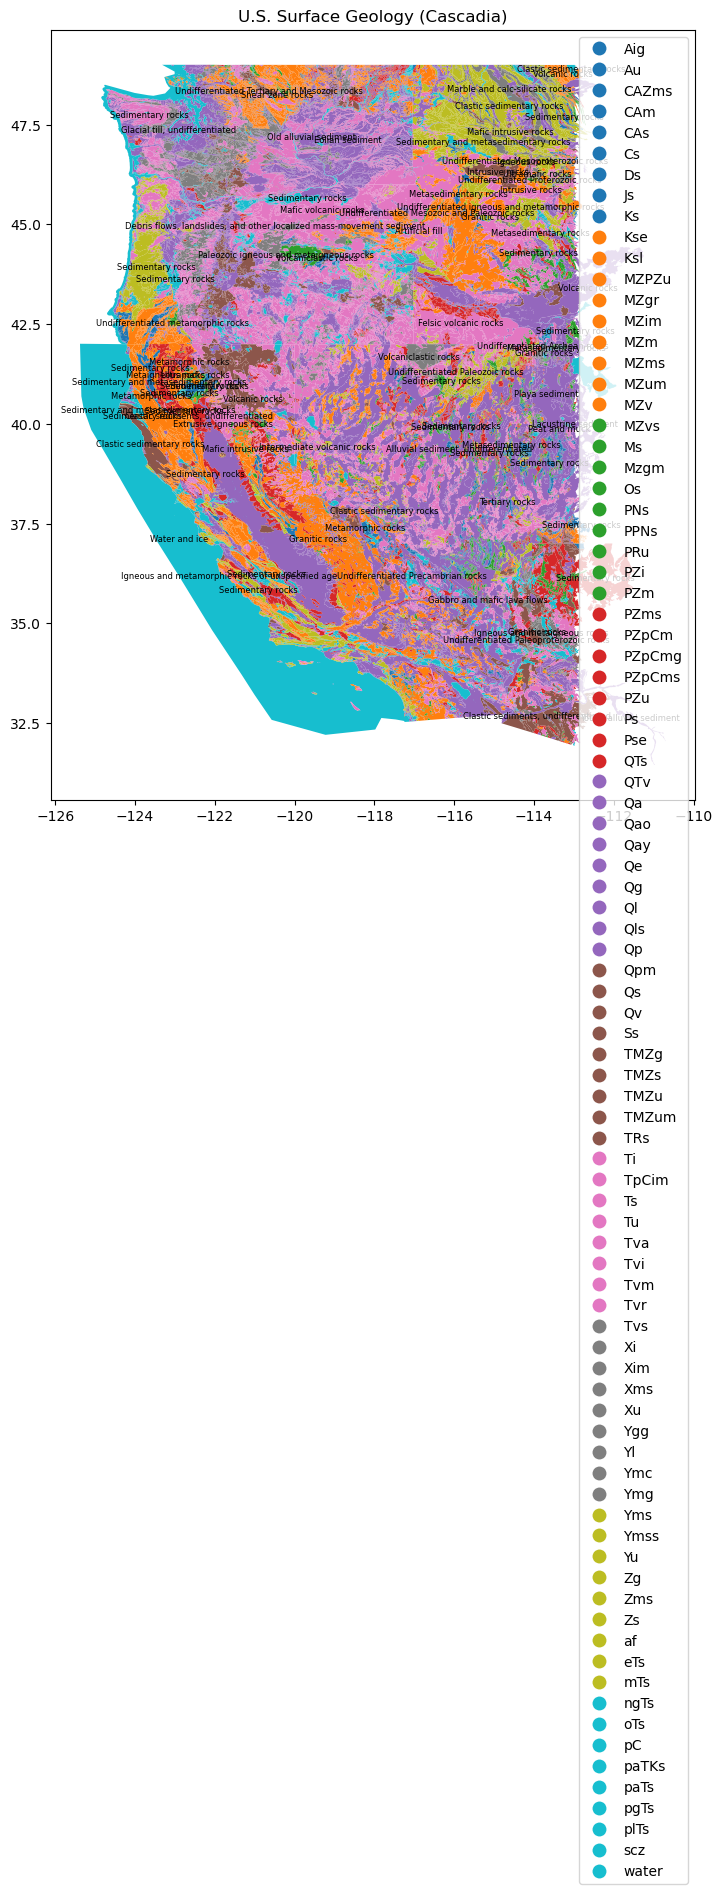

In [12]:
gdf_plot = gdf_joined.copy()
gdf_plot["geometry"] = gdf_plot.geometry.simplify(0.001, preserve_topology=True)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_plot.plot(
    ax=ax, column="MapUnit", categorical=True, legend=True,
    edgecolor="none", linewidth=0.05
)

# Label largest polygon per MapUnit to reduce clutter
labels = (gdf_plot.assign(_area=gdf_plot.geometry.area)
          .sort_values("_area", ascending=False)
          .drop_duplicates(subset="MapUnit"))
for _, row in labels.iterrows():
    x, y = row.geometry.representative_point().coords[0]  # safer than centroid for multipolygons
    ax.text(x, y, row["UnitName"] if row["UnitName"] else row["MapUnit"],
            fontsize=6, ha="center", va="center")

ax.set_title("U.S. Surface Geology (Cascadia)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()